In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [258]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Input, Flatten, Dense, Lambda
import tensorflow as tf

In [340]:
## Avoid overconsumption of GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [11]:
import os
print(os.getcwd())

/Users/AshishR_T/Desktop/Timepass python projects/Deep Learning Model


In [16]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [19]:
print(ANC_PATH)

data/anchor


In [23]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    cv2.imshow('Image Collection', frame)

    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [24]:
# Loading and PreProcessing our Images

In [25]:
# Getting the Image Directories
anchor = tf.data.Dataset.list_files(os.path.join(ANC_PATH, '*.jpg')).take(300)
positive = tf.data.Dataset.list_files(os.path.join(POS_PATH, '*.jpg')).take(300)
negative = tf.data.Dataset.list_files(os.path.join(NEG_PATH, '*.jpg')).take(300)

In [71]:
## Testing purposes!
dir_test = anchor.as_numpy_iterator()
dir_test.next()

b'data/anchor/5661dde2-f398-11ef-92dd-d2b34dc948be.jpg'

In [73]:
# PreProcessing - Scaling and Resizing
def preprocess (file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (105,105))
    img = img / 255.0
    return img

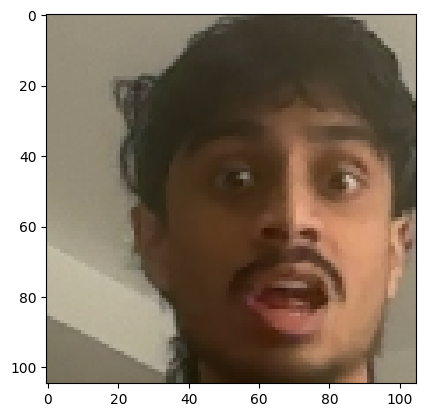

In [74]:
## Testing!
img = preprocess('data/anchor/5661dde2-f398-11ef-92dd-d2b34dc948be.jpg')
plt.imshow(img)
plt.show()

In [136]:
# Create Labelled Dataset
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [128]:
## Training purposes only!
samples = data.as_numpy_iterator()
for i in range(200):
    samples.next()
print(samples.next())

(b'data/anchor/9a403f9a-f398-11ef-92dd-d2b34dc948be.jpg', b'data/positive/1872577c-f399-11ef-92dd-d2b34dc948be.jpg', 1.0)


In [137]:
# Better function!
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

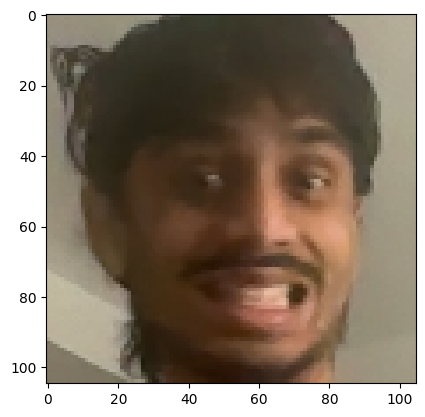

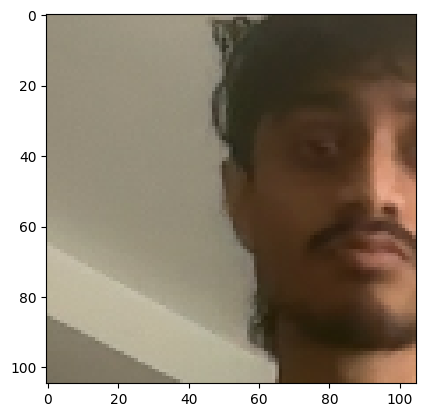

1.0

In [138]:
## Testing purposes!
test = preprocess_twin('data/positive/5829feb0-f399-11ef-92dd-d2b34dc948be.jpg', 'data/anchor/5f8c164e-f398-11ef-92dd-d2b34dc948be.jpg', 1.0)
plt.imshow(test[0])
plt.show()
plt.imshow(test[1])
plt.show()
test[2]

In [ ]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [ ]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16) # Divides the data into batches of 16 images each
train_data = train_data.prefetch(8) # Also could use AUTOTUNE method of tf so that it automatically decides the optimal number to prefetch

In [163]:
sample = train_data.as_numpy_iterator()
samp = sample.next()

In [171]:
samp[2]

array([0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0.],
      dtype=float32)

In [ ]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [ ]:
# Model Engineering

In [370]:
# Build Embedding Layer
def make_embedding():

    # Copy these and run for better comprehension
    inp = Input(name = "input_image", shape = (105,105,3))
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten() (c4)
    d1 = Dense( 4096, activation='sigmoid')(f1)

    return Model(inputs = inp, outputs = d1, name = 'embedding')

In [351]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 105, 105, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 96, 96, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 42, 42, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 18, 18, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [371]:
# Building Distance Layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, inputs):
        input_embedding, validation_embedding = inputs
        return tf.math.abs(input_embedding-validation_embedding)

In [353]:
# Making siamese model
def make_siamese_model():
    input_image = Input(name='input_img', shape=(105,105,3))
    validation_image = Input(name='validation_img', shape = (105,105,3))
    
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer([embedding(input_image), embedding(validation_image)])

    classifier = Dense(1, activation='sigmoid')(distances)
    return Model(inputs = [input_image, validation_image], outputs = classifier, name='SiameseNetwork')
     

In [354]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_15 (L1Dist) │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │      4,097 │ l1_dist_15[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training

In [355]:
# Setup Loss and Optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy() # Loss Function
opt = tf.keras.optimizers.Adam(1e-4) # Optimizer Function

In [356]:
# Establish Checkpoints
checkpoint_dir = '/Users/AshishR_T/Desktop/Timepass python projects/Deep Learning Model/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model)

In [302]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()

In [310]:
X = batch_1[:2]

In [318]:
y = batch_1[2]

In [324]:
yhat = siamese_model(X, training = True)
loss = binary_cross_loss(y, yhat)

In [326]:
loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.69249845>

In [357]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative 
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training = True) # y pred
        # Calculate loss
        loss = binary_cross_loss(y, yhat)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

In [384]:
# Build Traning Loop
def train(train_data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print(f'\nEpoch {epoch}/{EPOCHS}')
        
        # Progress after each batch is completed! (len(train_data) - returns the number of batches in the training dataset)
        progress_bar = tf.keras.utils.Progbar(len(train_data))

        # Loop through each batch (becuz train_data = train_data.batch(16) --> so we loop through each batch)
        for idx, batch in enumerate(train_data):
            # Run train step here
            train_step(batch)
            progress_bar.update(idx+1)

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)       

In [416]:
train(train_data, 50)


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 967ms/step

Epoch 2/50


2025-02-27 15:34:16.073592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 925ms/step

Epoch 3/50


2025-02-27 15:34:41.338319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 961ms/step

Epoch 4/50


2025-02-27 15:35:06.618288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 925ms/step

Epoch 5/50


2025-02-27 15:35:31.891779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 938ms/step

Epoch 6/50


2025-02-27 15:35:57.175172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 961ms/step

Epoch 7/50


2025-02-27 15:36:22.453102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 967ms/step

Epoch 8/50


2025-02-27 15:36:47.893915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 925ms/step

Epoch 9/50


2025-02-27 15:37:13.178017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 961ms/step

Epoch 10/50


2025-02-27 15:37:38.455339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 951ms/step


2025-02-27 15:38:03.758692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 969ms/step

Epoch 12/50


2025-02-27 15:38:29.537484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 937ms/step

Epoch 13/50


2025-02-27 15:38:54.807528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 966ms/step

Epoch 14/50


2025-02-27 15:39:20.217615: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 965ms/step

Epoch 15/50


2025-02-27 15:39:45.611750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 972ms/step

Epoch 16/50


2025-02-27 15:40:11.195705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 995ms/step

Epoch 17/50


2025-02-27 15:40:37.366732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 976ms/step

Epoch 18/50


2025-02-27 15:41:03.019166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 969ms/step

Epoch 19/50


2025-02-27 15:41:28.513823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 940ms/step

Epoch 20/50


2025-02-27 15:41:54.151672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 974ms/step


2025-02-27 15:42:19.770591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 21/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 961ms/step

Epoch 22/50


2025-02-27 15:42:45.347091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 938ms/step

Epoch 23/50


2025-02-27 15:43:10.622424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 961ms/step

Epoch 24/50


2025-02-27 15:43:35.910004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 961ms/step

Epoch 25/50


2025-02-27 15:44:01.190154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 963ms/step

Epoch 26/50


2025-02-27 15:44:26.539898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 931ms/step

Epoch 27/50


2025-02-27 15:44:51.966840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 962ms/step

Epoch 28/50


2025-02-27 15:45:17.268947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 938ms/step

Epoch 29/50


2025-02-27 15:45:42.534382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 961ms/step

Epoch 30/50


2025-02-27 15:46:07.815023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 929ms/step


2025-02-27 15:46:33.177720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 31/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 968ms/step

Epoch 32/50


2025-02-27 15:46:58.980163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 961ms/step

Epoch 33/50


2025-02-27 15:47:24.255005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 961ms/step

Epoch 34/50


2025-02-27 15:47:49.538348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 975ms/step

Epoch 35/50


2025-02-27 15:48:15.203271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 928ms/step

Epoch 36/50


2025-02-27 15:48:40.556099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 973ms/step

Epoch 37/50


2025-02-27 15:49:06.171348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 964ms/step

Epoch 38/50


2025-02-27 15:49:31.811612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 972ms/step

Epoch 39/50


2025-02-27 15:49:57.390087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 967ms/step

Epoch 40/50


2025-02-27 15:50:22.896917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 938ms/step


2025-02-27 15:50:48.518045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 41/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 966ms/step

Epoch 42/50


2025-02-27 15:51:14.037257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 966ms/step

Epoch 43/50


2025-02-27 15:51:39.457106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 959ms/step

Epoch 44/50


2025-02-27 15:52:04.870631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 968ms/step

Epoch 45/50


2025-02-27 15:52:30.506473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 964ms/step

Epoch 46/50


2025-02-27 15:52:55.855669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 971ms/step

Epoch 47/50


2025-02-27 15:53:21.474040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 967ms/step

Epoch 48/50


2025-02-27 15:53:46.921337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 960ms/step

Epoch 49/50


2025-02-27 15:54:12.196128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 993ms/step

Epoch 50/50


2025-02-27 15:54:38.330912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 966ms/step


2025-02-27 15:55:03.937606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [385]:
# Evaluate Model

In [417]:
from tensorflow.keras.metrics import Precision, Recall

In [418]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [432]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


array([[2.5553548e-10],
       [9.9999666e-01],
       [5.4360044e-08],
       [1.4586032e-08],
       [9.9999964e-01],
       [3.7928160e-07],
       [9.9997151e-01],
       [1.7881015e-10],
       [2.2476636e-10],
       [1.0000000e+00],
       [1.2940321e-11],
       [1.7428489e-07],
       [1.4905629e-07],
       [1.0000000e+00],
       [2.6515237e-10],
       [9.9998522e-01]], dtype=float32)

In [433]:
# Post processing the results
"""res = []
for prediction in y_hat:
    if prediction > 0.5:
        res.append(1)
    else:
        res.append(0)"""
# based on our model
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1]

In [434]:
# actual values - they seem to be matching - not a bad model!
y_true

array([0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

In [435]:
# Creating a metric object (Recall)
r = Recall()

# Calculate the recall value
r.update_state(y_true, y_hat)

# Return Recall Result
r.result().numpy()

1.0

In [436]:
# Creating a metric object (Precision)
p = Precision()

# Calculate the precision value
p.update_state(y_true, y_hat)

# Return Precision Result
p.result().numpy()

1.0

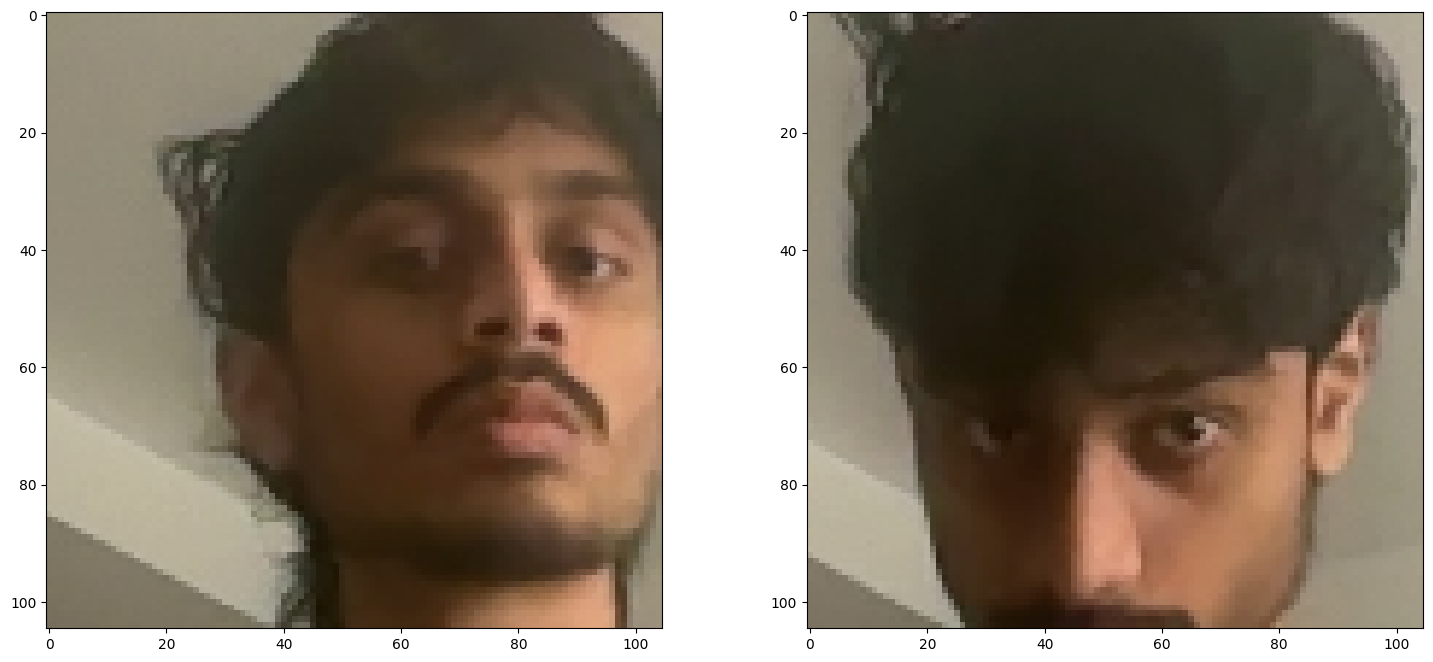

In [437]:
# Visualize Results

plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[15]) # --> Last Image ( we can see that they both match and the result is 1 )
plt.subplot(1,2,2)
plt.imshow(test_val[15]) # --> Test image
plt.show()

In [ ]:
# Saving Model

In [438]:
# Save weights
siamese_model.save('siameseModel.h5')

In [441]:
# Reload model
model = tf.keras.models.load_model('siameseModel.h5',
                                    custom_objects={'L1Dist': L1Dist, 
                                    'BinaryCrossentropy':tf.losses.BinaryCrossentropy()})

In [442]:
# Make predictions with our reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


array([[2.5553548e-10],
       [9.9999666e-01],
       [5.4360044e-08],
       [1.4586032e-08],
       [9.9999964e-01],
       [3.7928160e-07],
       [9.9997151e-01],
       [1.7881015e-10],
       [2.2476636e-10],
       [1.0000000e+00],
       [1.2940321e-11],
       [1.7428489e-07],
       [1.4905629e-07],
       [1.0000000e+00],
       [2.6515237e-10],
       [9.9998522e-01]], dtype=float32)

In [444]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_17 (L1Dist) │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │      4,097 │ l1_dist_17[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [445]:
# Real Time Test

In [474]:
# Verification function
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    # Looping through the verification images in the application_data folder
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        if not image.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):  # Ignore non-images
            continue
        # Assigning input_img input_image.jpg
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        # Preprocessing each image and assigning it to validation_img 
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        # Making predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    # Detection Threshold: Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified

In [502]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret or frame is None:
        print("Error: Failed to capture frame.")
        continue  # Skip this loop iteration and try again

    # Move the crop up
    frame = frame[250:500, 600:850, :]  # Ensure correct crop

    cv2.imshow('Verification', frame)

    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        results, verified = verify(model, 0.9, 0.5)
        print(verified)
        
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release() 
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

In [500]:
np.sum(np.squeeze(results) > 0.90)

16

In [501]:
16/50

0.32